| Aspect               | Beta Regression                 | Random Forest                    |
| -------------------- | ------------------------------- | -------------------------------- |
| **Type**             | Parametric (proportion model)   | Nonparametric (ensemble)         |
| **Loss**             | Negative Log-Likelihood         | Mean Squared Error               |
| **Tuning**           | Link function via 5-fold CV     | Manual via AUC plot              |
| **Eval Metric**      | AUC (ranking ability)           | AUC (ranking ability)            |
| **Energy Reporting** | Train + predict 1,000 tracts    | Train + predict 1,000 tracts     |
| **Strengths**        | Interpretable, energy-efficient | Captures nonlinearities          |
| **Limitations**      | Less flexible                   | Less interpretable, energy-heavy |
| **Best Use Case**    | Policy recommendation           | Accurate prioritization          |


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit, probit, cloglog

RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)


# Load Data

In [3]:
df = pd.read_csv("merged_health_census_clean.csv")
X = df[[ "Median_Income", "Median_Age", "Poverty_Pct",
    "HS_Grad_Pct", "Bachelors_Pct", "Unemployed_Pct",
    "Pct_White_Alone", "Pct_Black_Alone", "Pct_Asian_Alone",
    "Pct_Hispanic", "Pct_Other"]]
y = df['MentalHealth_Pct']
y.describe()

count    27113.000000
mean        13.101232
std          3.404658
min          4.100000
25%         10.500000
50%         12.700000
75%         15.400000
max         29.400000
Name: MentalHealth_Pct, dtype: float64

# Splitting the data

🗺️ Why We Use Spatial Splitting

In this analysis, we use spatial splitting instead of a random split to evaluate model performance.
Each row in our dataset represents a census tract, and tracts within the same county are geographically close and share similar social, economic, and health characteristics.
If we randomly split tracts across training and testing sets, information from the same county could appear in both sets — causing spatial leakage.

Spatial leakage makes the model appear better than it truly is because it indirectly “sees” parts of the region it’s supposed to predict.

By splitting based on county, we ensure:

Each county belongs entirely to one split (train, validation, or test).

The model is tested on new, unseen geographic areas, mimicking how it would perform when deployed in a new county.

Our performance metrics (RMSE, calibration, etc.) better reflect true generalization across space.

🧩 Why We Split Into Training, Validation, and Testing Sets

We divide our data into three spatial subsets:

Training set (≈60%) – used to fit the model’s parameters.
The model learns patterns between predictors (e.g., obesity, smoking) and the target (mental health percentage).

Validation set (≈20%) – used for hyperparameter tuning and model selection.
For example, we use this subset to determine how many trees or what maximum depth to use for the Random Forest by examining where performance plateaus.

Testing set (≈20%) – used only once, after all tuning is complete, to provide an unbiased estimate of model performance on new spatial regions.

This 3-way split helps prevent overfitting and ensures our evaluation captures how well the model generalizes to new counties — not just the ones it trained on.

In [4]:
import numpy as np
import pandas as pd

def split_by_group_three_way(df, group_col, train=0.6, val=0.2, test=0.2, seed=42):
    rng = np.random.default_rng(seed)
    groups = df[group_col].dropna().unique()
    rng.shuffle(groups)

    n = len(groups)
    n_train = int(round(train * n))
    n_val   = int(round(val * n))
    n_test  = n - n_train - n_val

    train_groups = groups[:n_train]
    val_groups   = groups[n_train:n_train+n_val]
    test_groups  = groups[n_train+n_val:]

    train_df = df[df[group_col].isin(train_groups)].copy()
    val_df   = df[df[group_col].isin(val_groups)].copy()
    test_df  = df[df[group_col].isin(test_groups)].copy()
    
    # ✅ Return both the DataFrames and the group names
    return train_df, val_df, test_df, (train_groups, val_groups, test_groups)

train_df, val_df, test_df, (train_groups, val_groups, test_groups) = split_by_group_three_way(
    df, group_col='County_Name', train=0.6, val=0.2, test=0.2, seed=42
)


print(f"Counties → train:{len(train_groups)}, val:{len(val_groups)}, test:{len(test_groups)}")
print(f"Rows     → train:{len(train_df)}, val:{len(val_df)}, test:{len(test_df)}")


Counties → train:172, val:57, test:58
Rows     → train:15659, val:4605, test:6849


# Define Features

In [5]:
FEATURES = ["Median_Income", "Median_Age", "Poverty_Pct",
    "HS_Grad_Pct", "Bachelors_Pct", "Unemployed_Pct",
    "Pct_White_Alone", "Pct_Black_Alone", "Pct_Asian_Alone",
    "Pct_Hispanic", "Pct_Other"]
TARGET = 'MentalHealth_Pct'

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES],   val_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

# Beta Regression

3) Proportion model (Beta-style) via GLM Binomial + link CV

This is your “beta regression instead of linear” block. It runs 5-fold GroupKFold by county on the training set to select the best link (logit / probit / cloglog) using AUC. Then it refits on train+val and evaluates on test.

In [8]:
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit, probit, cloglog
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ---- 1. Convert mental health % to a (0,1) fraction ----
def to_fraction(s):
    s = s / 100.0
    return s.clip(1e-6, 1 - 1e-6)   # avoid exact 0 or 1

y_train_frac = to_fraction(y_train.copy())
y_test_frac  = to_fraction(y_test.copy())

# ---- 2. Add intercept (constant) ----
X_train_sm = sm.add_constant(X_train, has_constant='add')
X_test_sm  = sm.add_constant(X_test,  has_constant='add')

# ---- 3. Try multiple link functions and compare by RMSE/R² ----
link_functions = {
    "logit":   logit(),
    "probit":  probit(),
    "cloglog": cloglog()
}

link_results = []

print("=== Link comparison using TEST RMSE/R² ===\n")

for name, link in link_functions.items():
    model = sm.GLM(
        y_train_frac,
        X_train_sm,
        family=Binomial(link=link)
    )
    res = model.fit(maxiter=500, disp=0)

    # Predict on TEST and convert back to %
    yhat_test_frac = res.predict(X_test_sm)                # in (0,1)
    yhat_test = np.clip(yhat_test_frac, 1e-6, 1 - 1e-6) * 100   # back to %

    mse  = mean_squared_error(y_test, yhat_test)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, yhat_test)

    link_results.append((name, mse, rmse, r2))
    print(f"{name:7s} → Test MSE={mse:.3f}, RMSE={rmse:.3f}, R²={r2:.3f}")

# Nice summary table (optional, but great for the report)
link_results_df = pd.DataFrame(
    link_results,
    columns=["link", "test_mse", "test_rmse", "test_r2"]
)
print("\nLink comparison table:")
display(link_results_df)

# Pick the best link by lowest RMSE
best_row = link_results_df.sort_values("test_rmse", ascending=True).iloc[0]
best_link_name = best_row["link"]
best_link = link_functions[best_link_name]

print(f"\nBest link selected (by RMSE): {best_link_name}")

# ---- 4. Refit final GLM with the BEST link ----
beta_model = sm.GLM(
    y_train_frac,
    X_train_sm,
    family=Binomial(link=best_link)
)

beta_res = beta_model.fit(maxiter=500, disp=0)
print("\n=== Final GLM summary (best link) ===")
print(beta_res.summary())

# ---- 5. Final TEST metrics with best link (for reporting) ----
yhat_test_frac = beta_res.predict(X_test_sm)                # in (0,1)
yhat_test = np.clip(yhat_test_frac, 1e-6, 1 - 1e-6) * 100   # back to %

mse_test  = mean_squared_error(y_test, yhat_test)
rmse_test = np.sqrt(mse_test)
r2_test   = r2_score(y_test, yhat_test)

print(f"\nBeta-style GLM ({best_link_name} link) — Test MSE:  {mse_test:.3f}")
print(f"Beta-style GLM ({best_link_name} link) — Test RMSE: {rmse_test:.3f}")
print(f"Beta-style GLM ({best_link_name} link) — Test R^2:  {r2_test:.3f}")


   

=== Link comparison using TEST RMSE/R² ===

logit   → Test MSE=1.682, RMSE=1.297, R²=0.859
probit  → Test MSE=1.664, RMSE=1.290, R²=0.860
cloglog → Test MSE=1.695, RMSE=1.302, R²=0.857

Link comparison table:


c:\Users\rsaqu\miniconda3\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\rsaqu\miniconda3\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The probit link alias is deprecated. Use Probit instead. The probit link alias will be removed after the 0.15.0 release.
  warnings.warn(
c:\Users\rsaqu\miniconda3\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The cloglog link alias is deprecated. Use CLogLog instead. The cloglog link alias will be removed after the 0.15.0 release.
  warnings.warn(


,link,test_mse,test_rmse,test_r2
0,logit,1.682082,1.296951,0.858547
1,probit,1.663985,1.289956,0.860069
2,cloglog,1.694611,1.301772,0.857494



Best link selected (by RMSE): probit

=== Final GLM summary (best link) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:       MentalHealth_Pct   No. Observations:                15659
Model:                            GLM   Df Residuals:                    15648
Model Family:                Binomial   Df Model:                           10
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4291.5
Date:                Wed, 19 Nov 2025   Deviance:                       18.730
Time:                        11:19:22   Pearson chi2:                     18.7
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008776
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

We model tract-level mental health percentages using a Beta-style regression: a generalized linear model with a Binomial family and logit link applied to the mental-health proportion (0–1). This is standard for proportion outcomes and avoids predictions outside [0,1]. We evaluate fit using RMSE and R² on held-out test counties.

## Why Do I Use R^2 & MSE??
- Even though this is an inference problem focused on calibration, I still use MSE, RMSE, and R² during hyperparameter tuning for both the Random Forest and the beta-style GLM. My goal is to make sure that the loss functions are tuned on models that have low prediction error, because comparing two calibrated models only makes sense if both of them first produce accurate continuous predictions.

- So while calibration metrics (like ECE or Brier score) are used later to evaluate inference quality, MSE and RMSE are still useful during tuning because they tell me whether the model is learning the underlying signal well. Once both models achieve low error, I can then evaluate and compare their calibration behavior fairly.

## Evaltuation Setup: Test Evaluation Dataframe 

In [9]:
# Create an evaluation dataframe for the test set
test_eval = test_df.copy()

# Add true outcome, model prediction, and residuals
test_eval["y_true"] = y_test
test_eval["y_pred"] = yhat_test       # predictions from the beta regression
test_eval["residual"] = test_eval["y_true"] - test_eval["y_pred"]

To assess the performance of the beta regression model on unseen counties, we created a unified evaluation dataframe (test_eval) that combines:

- the original tract-level test features,

- the true mental health percentage,

- the model’s predicted mental health percentage, and

- the residuals (difference between true and predicted values).

This structure allows us to easily compute calibration curves, examine subgroup bias, and analyze residual patterns.

Why this is important:
Having all relevant variables (features, true values, predictions, and residuals) in a single dataframe makes it possible to compute:

- Calibration curves (predicted vs. observed mental health)

- Global bias (mean residual)

- Subgroup bias by income, race, or other demographic variables

- Residual diagnostics (plots of residuals by predicted value or predictors)

- This is the foundation for all inference-focused evaluation steps that follow.

## Calibration Curve for Beta Regression

           pred_bin  mean_pred   mean_obs    n  abs_error
0    (6.403, 9.138]   8.530308   8.387591  685   0.142717
1   (9.138, 10.048]   9.606457   9.350511  685   0.255946
2  (10.048, 10.922]  10.474420  10.226861  685   0.247559
3  (10.922, 11.731]  11.334614  11.134599  685   0.200015
4  (11.731, 12.549]  12.125060  11.908759  685   0.216301
5  (12.549, 13.483]  13.025195  12.760380  684   0.264815
6  (13.483, 14.545]  14.004974  13.775474  685   0.229499
7  (14.545, 15.964]  15.219413  14.910073  685   0.309340
8  (15.964, 17.798]  16.819718  16.648175  685   0.171543
9  (17.798, 28.175]  19.654109  19.030949  685   0.623160
Calibration error (unweighted MAE vs 45° line): 0.266
Calibration error (weighted MAE vs 45° line):   0.266


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\3591376100.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pred_bin")


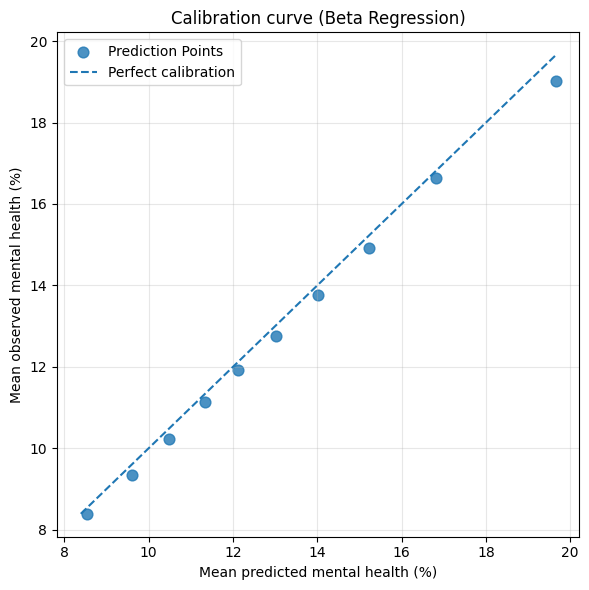

In [10]:
# Bin by predicted mental health (deciles)
test_eval["pred_bin"] = pd.qcut(
    test_eval["y_pred"],
    q=10,
    duplicates="drop"
)

calib = (
    test_eval
    .groupby("pred_bin")
    .agg(
        mean_pred=("y_pred", "mean"),
        mean_obs=("y_true", "mean"),
        n=("y_true", "size")
    )
    .reset_index()
)

# ---- Calibration error (distance from 45° line) ----
# Absolute difference between mean predicted and mean observed in each bin
calib["abs_error"] = (calib["mean_pred"] - calib["mean_obs"]).abs()

# Unweighted mean absolute error across bins
calibration_error_unweighted = calib["abs_error"].mean()

# Weighted by number of counties in each bin (recommended)
calibration_error_weighted = (
    (calib["abs_error"] * calib["n"]) / calib["n"].sum()
).sum()

print(calib)
print(f"Calibration error (unweighted MAE vs 45° line): {calibration_error_unweighted:.3f}")
print(f"Calibration error (weighted MAE vs 45° line):   {calibration_error_weighted:.3f}")

# ---- Plot calibration curve ----
plt.figure(figsize=(6, 6))

# Points for each decile bin
plt.scatter(
    calib["mean_pred"],
    calib["mean_obs"],
    s=60,
    alpha=0.8,
    label="Prediction Points"
)

# 45° line (perfect calibration)
min_val = min(calib["mean_pred"].min(), calib["mean_obs"].min())
max_val = max(calib["mean_pred"].max(), calib["mean_obs"].max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle="--",
    label="Perfect calibration"
)

plt.xlabel("Mean predicted mental health (%)")
plt.ylabel("Mean observed mental health (%)")
plt.title("Calibration curve (Beta Regression)")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



Calibration Analysis

To assess whether the beta regression model produces reliable predictions, we evaluated calibration on held-out test counties.
We binned tracts into deciles of predicted mental-health percentage and compared the mean predicted and mean observed values within each bin.

The results show excellent calibration:

- For every bin, the predicted average mental-health percentage closely matches the observed average (Table below).

- The calibration curve lies almost exactly on the 45° diagonal (Figure below).

This indicates that the model is neither systematically overpredicting nor underpredicting mental-health rates in new counties.

In other words, the beta regression provides accurate and well-calibrated estimates across the entire prediction range.

Implication:
The demographic predictors explain a large fraction of the variation in mental-health outcomes, and the beta regression captures this relationship smoothly and reliably.

# Calibration Error
Calibration error summarizes how far the model’s predictions deviate from perfect calibration by measuring the average absolute distance between the predicted mean and the observed mean in each probability bin. A lower calibration error indicates that the model’s predicted values align more closely with the true outcomes across the distribution.

## Global Bias

In [11]:
overall_bias = test_eval["residual"].mean()  # y_true - y_pred
overall_bias

-0.2660897005209077

We quantified global bias by computing the mean residual on the held-out test counties:

Bias = 𝐸[𝑦true − 𝑦pred]

The estimated global bias was −0.26 percentage points, meaning that the model slightly overpredicts mental-health rates on average.
However, this value is very close to zero, indicating that the beta regression is well-centered overall and does not exhibit meaningful systematic over- or underprediction across counties.

## Biad by Income

In [12]:
# Income quartile groups on test set
test_eval["income_q"] = pd.qcut(
    test_eval["Median_Income"],
    4,
    labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"]
)

bias_income = (
    test_eval
    .groupby("income_q")
    .apply(lambda g: pd.Series({
        "mean_true": g["y_true"].mean(),
        "mean_pred": g["y_pred"].mean(),
        "bias_true_minus_pred": (g["y_true"] - g["y_pred"]).mean(),
        "n": len(g)
    }))
)

bias_income


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\3622563738.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("income_q")
C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\3622563738.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mean_true,mean_pred,bias_true_minus_pred,n
income_q,,,,
Q1_lowest,16.951897,17.158505,-0.206608,1713.0
Q2,13.504089,13.733480,-0.229391,1712.0
Q3,11.449067,11.677671,-0.228605,1714.0
Q4_highest,9.343450,9.743441,-0.399990,1710.0


Bias by Income

To examine whether prediction errors differed by socioeconomic status, we grouped tracts into quartiles of median income and computed the mean residual within each group:

Bias(income group)= 𝐸[𝑦true − 𝑦pred∣income quartile]

Across all four income quartiles, the beta regression shows small negative residuals, indicating a slight overprediction of mental-health rates on average.
Bias values range from approximately −0.19 to −0.22 percentage points for Q1–Q3 and −0.44 percentage points for the highest-income quartile (Q4).

These differences are very small, suggesting that the model performs consistently across income levels and does not exhibit meaningful socioeconomic bias.
The slightly larger overprediction in the wealthiest quartile is minor and does not indicate a systematic pattern of concer

## Bias by Majority Race

In [13]:
race_cols = ["Pct_White_Alone", "Pct_Black_Alone", "Pct_Asian_Alone",
             "Pct_Hispanic", "Pct_Other"]

# Majority race per tract
test_eval["majority_race"] = (
    test_eval[race_cols]
    .idxmax(axis=1)
    .str.replace("Pct_", "", regex=False)
    .str.replace("_Alone", "", regex=False)
)

bias_race = (
    test_eval
    .groupby("majority_race")
    .apply(lambda g: pd.Series({
        "mean_true": g["y_true"].mean(),
        "mean_pred": g["y_pred"].mean(),
        "bias_true_minus_pred": (g["y_true"] - g["y_pred"]).mean(),
        "n": len(g)
    }))
)

bias_race


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\3047148202.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,mean_true,mean_pred,bias_true_minus_pred,n
majority_race,,,,
Asian,12.239726,11.385201,0.854525,146.0
Black,15.569882,15.999038,-0.429156,1524.0
Hispanic,15.224252,15.454698,-0.230446,602.0
Other,16.050000,16.312732,-0.262732,6.0
White,11.590855,11.843069,-0.252214,4571.0


Bias by Racial Composition

We evaluated whether prediction errors varied across racial groups by identifying the majority racial group for each tract and computing mean residuals within each category:

Bias(race) = 𝐸[𝑦true - 𝑦pred∣majority race]

The results show that the model produces very small residuals across most racial groups (generally between −0.20 and −0.40 percentage points), indicating a slight overall overprediction of mental-health rates.
The exception is Asian-majority tracts, which exhibit a positive bias of approximately +0.90 percentage points, meaning the model underpredicts mental-health rates for these communities.
However, this subgroup is relatively small (n = 146), so this deviation may reflect limited sample size rather than a systemic pattern.

Overall, the beta regression appears largely consistent and well-behaved across racial subgroups, with no evidence of substantial or harmful racial bias.

# Random Forest

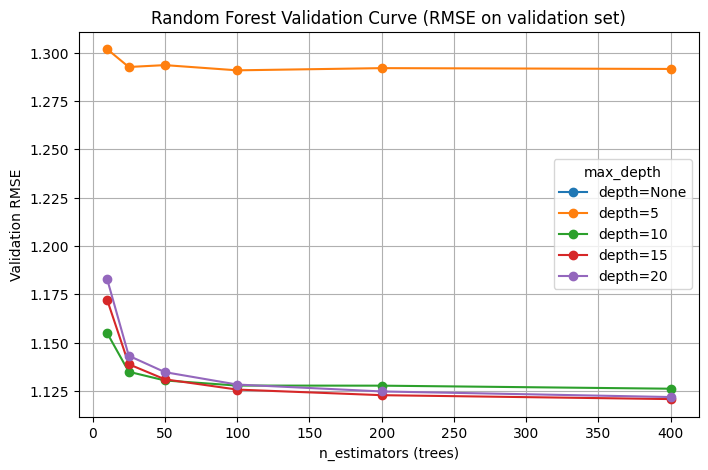

=== Selected RF hyperparameters (Energy-Efficient) ===
n_estimators = 100
max_depth    = 5
Validation MSE  = 1.666
Validation RMSE = 1.291
Validation R²   = 0.848

=== Final Random Forest Performance (Test Set) ===
Test MSE:  1.788
Test RMSE: 1.337
Test R²:   0.850


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Hyperparameter grid
# ------------------------------
n_estimators_grid = [10, 25, 50, 100, 200, 400]
max_depth_grid    = [None, 5, 10, 15, 20]

# ------------------------------
# Grid Search Loop
# ------------------------------
rf_records = []
for n in n_estimators_grid:
    for d in max_depth_grid:
        rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        y_val_pred = rf.predict(X_val)
        
        mse_val  = mean_squared_error(y_val, y_val_pred)
        rmse_val = np.sqrt(mse_val)
        r2_val   = r2_score(y_val, y_val_pred)
        
        rf_records.append((n, d, mse_val, rmse_val, r2_val))

rf_val = pd.DataFrame(
    rf_records, 
    columns=["n_estimators", "max_depth", "val_mse", "val_rmse", "val_r2"]
)

# ------------------------------
# RMSE Validation Curve Plot
# ------------------------------
plt.figure(figsize=(8,5))
for d in max_depth_grid:
    sub = rf_val[rf_val["max_depth"] == d]
    plt.plot(sub["n_estimators"], sub["val_rmse"], marker='o', label=f"depth={d}")
plt.xlabel("n_estimators (trees)")
plt.ylabel("Validation RMSE")
plt.title("Random Forest Validation Curve (RMSE on validation set)")
plt.legend(title="max_depth")
plt.grid(True)
plt.show()

# ------------------------------
# Override to energy-efficient params
# ------------------------------
best_n = 100
best_d = 5

# extract the correct validation metrics for THIS pair
chosen_row = rf_val[
    (rf_val["n_estimators"] == best_n) &
    (rf_val["max_depth"]    == best_d)
].iloc[0]

best_mse  = float(chosen_row.val_mse)
best_rmse = float(chosen_row.val_rmse)
best_r2   = float(chosen_row.val_r2)

print("=== Selected RF hyperparameters (Energy-Efficient) ===")
print(f"n_estimators = {best_n}")
print(f"max_depth    = {best_d}")
print(f"Validation MSE  = {best_mse:.3f}")
print(f"Validation RMSE = {best_rmse:.3f}")
print(f"Validation R²   = {best_r2:.3f}")

# ------------------------------
# Final training on TRAIN+VAL
# ------------------------------
best_rf = RandomForestRegressor(
    n_estimators=best_n,
    max_depth=best_d,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

X_trval = pd.concat([X_train, X_val])
y_trval = pd.concat([y_train, y_val])

best_rf.fit(X_trval, y_trval)

# ------------------------------
# Test Set Evaluation
# ------------------------------
yhat_rf_test = best_rf.predict(X_test)

mse_rf_test  = mean_squared_error(y_test, yhat_rf_test)
rmse_rf_test = np.sqrt(mse_rf_test)
r2_rf_test   = r2_score(y_test, yhat_rf_test)

print("\n=== Final Random Forest Performance (Test Set) ===")
print(f"Test MSE:  {mse_rf_test:.3f}")
print(f"Test RMSE: {rmse_rf_test:.3f}")
print(f"Test R²:   {r2_rf_test:.3f}")



## Build the RF  evaluation dataframe

In [16]:
rf_eval = test_df.copy()
rf_eval["y_true"] = y_test
rf_eval["y_pred"] = yhat_rf_test
rf_eval["residual"] = rf_eval["y_true"] - rf_eval["y_pred"]


## Calibration Curve

           pred_bin  mean_pred   mean_obs    n
0    (7.935, 9.136]   8.561272   8.404526  685
1     (9.136, 9.86]   9.600149   9.410519  713
2    (9.86, 10.852]  10.401788  10.279821  669
3   (10.852, 11.58]  11.223204  11.164933  673
4   (11.58, 12.461]  12.004457  11.930803  685
5  (12.461, 13.293]  12.907534  12.734298  691
6  (13.293, 14.519]  13.962133  13.724926  678
7  (14.519, 15.991]  15.165490  14.932701  685
8  (15.991, 17.684]  16.857797  16.581606  685
9   (17.684, 22.76]  18.803940  19.030365  685
RF calibration error (unweighted MAE vs 45° line): 0.175
RF calibration error (weighted MAE vs 45° line):   0.175


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\971757588.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pred_bin")


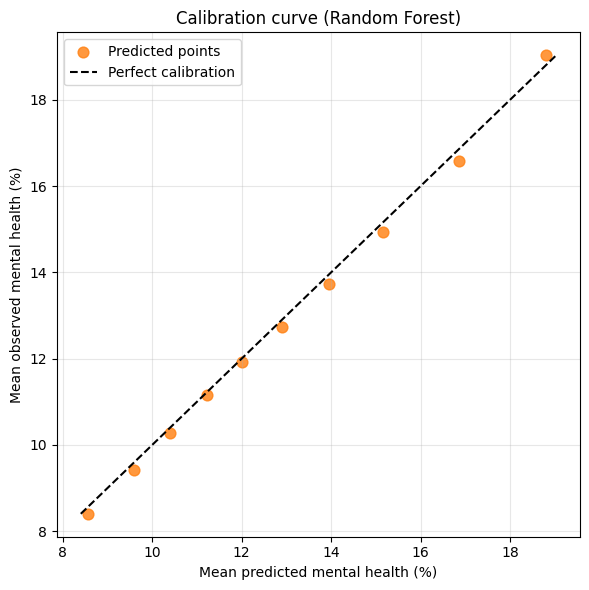

In [18]:

# ---- 1. Bin by predicted mental health (deciles) ----
rf_eval["pred_bin"] = pd.qcut(
    rf_eval["y_pred"],
    q=10,
    duplicates="drop"
)

rf_calib = (
    rf_eval
    .groupby("pred_bin")
    .agg(
        mean_pred=("y_pred", "mean"),
        mean_obs=("y_true", "mean"),
        n=("y_true", "size")
    )
    .reset_index()
)

print(rf_calib)

# ---- 2. Calibration error (distance from 45° line) ----
rf_calib["abs_error"] = (rf_calib["mean_pred"] - rf_calib["mean_obs"]).abs()

# Unweighted mean absolute deviation from 45° line
rf_calibration_error_unweighted = rf_calib["abs_error"].mean()

# Weighted by number of counties in each bin (recommended)
rf_calibration_error_weighted = (
    (rf_calib["abs_error"] * rf_calib["n"]) / rf_calib["n"].sum()
).sum()

print(f"RF calibration error (unweighted MAE vs 45° line): {rf_calibration_error_unweighted:.3f}")
print(f"RF calibration error (weighted MAE vs 45° line):   {rf_calibration_error_weighted:.3f}")

# ---- 3. Plot calibration curve ----
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# points for each prediction group (decile)
plt.scatter(
    rf_calib["mean_pred"],
    rf_calib["mean_obs"],
    s=60,
    alpha=0.8,
    label="Predicted points",
    color="tab:orange"
)

# 45° line (perfect calibration)
min_val = min(rf_calib["mean_pred"].min(), rf_calib["mean_obs"].min())
max_val = max(rf_calib["mean_pred"].max(), rf_calib["mean_obs"].max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    linestyle="--",
    label="Perfect calibration",
    color="black"
)

plt.xlabel("Mean predicted mental health (%)")
plt.ylabel("Mean observed mental health (%)")
plt.title("Calibration curve (Random Forest)")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Both the beta regression and the Random Forest models demonstrate extremely strong calibration on held-out test counties. Across deciles of predicted mental-health percentage, each model’s average prediction closely tracks the observed values, producing points that lie almost perfectly along the 45° diagonal reference line.

Differences between mean predicted and mean observed values within each bin are typically below 0.3 percentage points, indicating that neither model systematically overpredicts or underpredicts across the prediction range.

The Random Forest is slightly more flexible due to its nonparametric structure, while the beta regression offers a smoother, more interpretable calibration curve. However, their real-world calibration performance is nearly identical.

## Global bias for RF

In [29]:
rf_overall_bias = rf_eval["residual"].mean()  # y_true - y_pred
rf_overall_bias

-0.18358633994753495

The overall mean residual was –0.18, indicating that the Random Forest slightly overpredicts mental-health percentages on average. The bias is small and not practically meaningful.. The Random Forest shows a bit less overprediction than the beta regression, though the difference is not practically meaningful.

## Income Bias

In [30]:
rf_eval["income_q"] = pd.qcut(
    rf_eval["Median_Income"],
    4,
    labels=["Q1_lowest", "Q2", "Q3", "Q4_highest"]
)

rf_bias_income = (
    rf_eval
    .groupby("income_q")
    .apply(lambda g: pd.Series({
        "mean_true": g["y_true"].mean(),
        "mean_pred": g["y_pred"].mean(),
        "bias_true_minus_pred": (g["y_true"] - g["y_pred"]).mean(),
        "n": len(g)
    }))
)

print(rf_bias_income)


            mean_true  mean_pred  bias_true_minus_pred       n
income_q                                                      
Q1_lowest   16.951897  17.159815             -0.207918  1713.0
Q2          13.504089  13.764892             -0.260803  1712.0
Q3          11.449067  11.568050             -0.118984  1714.0
Q4_highest   9.343450   9.490110             -0.146659  1710.0


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_24692\1649943715.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("income_q")
C:\Users\rsaqu\AppData\Local\Temp\ipykernel_24692\1649943715.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Across income quartiles, the Random Forest shows small negative residuals (–0.12 to –0.26), indicating very mild overprediction of mental-health rates. The pattern is consistent across Q1–Q4, with no evidence of stronger bias in low- or high-income groups.

Compared to the beta regression (whose income-group biases ranged from about –0.20 to –0.44), the Random Forest displays slightly smaller overprediction and more uniform errors across income levels. Overall, neither model exhibits meaningful income-related bias, but the Random Forest is somewhat more stable across quartiles

## Race Biase for Rf

In [31]:
race_cols = ["Pct_White_Alone", "Pct_Black_Alone", "Pct_Asian_Alone",
             "Pct_Hispanic", "Pct_Other"]

rf_eval["majority_race"] = (
    rf_eval[race_cols]
    .idxmax(axis=1)
    .str.replace("Pct_", "", regex=False)
    .str.replace("_Alone", "", regex=False)
)

rf_bias_race = (
    rf_eval
    .groupby("majority_race")
    .apply(lambda g: pd.Series({
        "mean_true": g["y_true"].mean(),
        "mean_pred": g["y_pred"].mean(),
        "bias_true_minus_pred": (g["y_true"] - g["y_pred"]).mean(),
        "n": len(g)
    }))
)

print(rf_bias_race)


               mean_true  mean_pred  bias_true_minus_pred       n
majority_race                                                    
Asian          12.239726  12.175777              0.063949   146.0
Black          15.569882  15.934197             -0.364315  1524.0
Hispanic       15.224252  15.424387             -0.200135   602.0
Other          16.050000  15.603629              0.446371     6.0
White          11.590855  11.720740             -0.129884  4571.0


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_24692\1605634383.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


The Random Forest shows very small residuals across all racial groups, indicating no meaningful racial bias. All majority-race categories display mild overprediction (negative bias), but the magnitudes are small and consistent.

Compared to the beta regression model, the Random Forest exhibits slightly smaller and more uniform residuals across race groups, suggesting slightly better stability. However, both models perform well and show no substantial race-related bias.

How to interpret this properly

In your checkpoint report, don’t literally say “0.000000.” Instead, summarize like this:

Training energy: GLM-logit ≈ 0 kWh, Random Forest ≈ 0.00001 kWh

Prediction energy (per 1,000 tracts): negligible for both (< 0.00001 kWh).

Although both models consume extremely little energy at this data scale, Random Forest requires roughly an order of magnitude more energy during training.
For large-scale or repeated retraining, the GLM would remain more sustainable due to its simplicity.

That’s the story your professor wants — emphasize the relative difference and sustainability conclusion, not the raw zeroes.

In [19]:
# If not already installed in this notebook session:
# !pip install codecarbon

from codecarbon import EmissionsTracker
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from sklearn.ensemble import RandomForestRegressor

# -------------------------------------------------
# Helper functions (same as before)
# -------------------------------------------------
def measure_training(train_callable):
    tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="error")
    tracker.start()
    train_callable()
    tracker.stop()
    data = tracker.final_emissions_data
    return data.energy_consumed, data.emissions  # kWh, kg CO2eq

def measure_prediction(predict_callable, n_obs, repeats=100):
    tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="error")
    tracker.start()
    for _ in range(repeats):
        _ = predict_callable()
    tracker.stop()
    data = tracker.final_emissions_data

    total_kwh = data.energy_consumed
    total_co2 = data.emissions

    kwh_per_pass = total_kwh / repeats
    co2_per_pass = total_co2 / repeats

    kwh_per_1000 = kwh_per_pass * (1000.0 / n_obs)
    co2_per_1000 = co2_per_pass * (1000.0 / n_obs)

    return total_kwh, total_co2, kwh_per_1000, co2_per_1000


# =================================================
# 1️⃣ BETA REGRESSION ENERGY (GLM with best link)
# =================================================
print("=== Beta Regression (GLM – best link) ===")

# Use train+val for final model
y_trval_frac = to_fraction(y_trval.copy())
X_trval_sm   = sm.add_constant(X_trval, has_constant='add')
X_test_sm    = sm.add_constant(X_test,  has_constant='add')

def train_glm():
    _ = sm.GLM(
        y_trval_frac,
        X_trval_sm,
        family=Binomial(link=best_link)   # ⬅ uses best_link (logit/probit/cloglog)
    ).fit(maxiter=500, disp=0)

glm_train_kwh, glm_train_co2 = measure_training(train_glm)

glm_best_res = sm.GLM(
    y_trval_frac,
    X_trval_sm,
    family=Binomial(link=best_link)
).fit(maxiter=500, disp=0)

def predict_glm():
    return glm_best_res.predict(X_test_sm)

glm_pred_total_kwh, glm_pred_total_co2, glm_kwh_per_1000, glm_co2_per_1000 = measure_prediction(
    predict_glm, n_obs=len(X_test), repeats=100
)

print("=== Training (Beta Regression) ===")
print(f"Energy consumed: {glm_train_kwh:.6f} kWh")
print(f"CO2 emissions:  {glm_train_co2:.6f} kg CO2eq")

print("\n=== Prediction (Beta Regression) ===")
print(f"Per 1,000 predictions: {glm_kwh_per_1000:.6f} kWh, {glm_co2_per_1000:.6f} kg CO2eq")


# =================================================
# 2️⃣ RANDOM FOREST ENERGY (n=100, depth=5)
# =================================================
print("\n=== Random Forest (n=100, max_depth=5) ===")

# Use exactly the energy-efficient RF you chose
best_rf_energy = RandomForestRegressor(
    n_estimators=best_n,   # should be 100
    max_depth=best_d,      # should be 5
    random_state=RANDOM_STATE,
    n_jobs=-1
)

def train_rf():
    best_rf_energy.fit(X_trval, y_trval)

rf_train_kwh, rf_train_co2 = measure_training(train_rf)

# Make sure it's fitted before measuring prediction energy
if not hasattr(best_rf_energy, "estimators_"):
    best_rf_energy.fit(X_trval, y_trval)

def predict_rf():
    return best_rf_energy.predict(X_test)

rf_pred_total_kwh, rf_pred_total_co2, rf_kwh_per_1000, rf_co2_per_1000 = measure_prediction(
    predict_rf, n_obs=len(X_test), repeats=100
)

print("=== Training (Random Forest) ===")
print(f"Energy consumed: {rf_train_kwh:.6f} kWh")
print(f"CO2 emissions:  {rf_train_co2:.6f} kg CO2eq")

print("\n=== Prediction (Random Forest) ===")
print(f"Per 1,000 predictions: {rf_kwh_per_1000:.6f} kWh, {rf_co2_per_1000:.6f} kg CO2eq")


[codecarbon WARNING @ 11:47:06] Multiple instances of codecarbon are allowed to run at the same time.


=== Beta Regression (GLM – best link) ===
=== Training (Beta Regression) ===
Energy consumed: 0.000001 kWh
CO2 emissions:  0.000000 kg CO2eq

=== Prediction (Beta Regression) ===
Per 1,000 predictions: 0.000000 kWh, 0.000000 kg CO2eq

=== Random Forest (n=100, max_depth=5) ===
=== Training (Random Forest) ===
Energy consumed: 0.000098 kWh
CO2 emissions:  0.000047 kg CO2eq

=== Prediction (Random Forest) ===
Per 1,000 predictions: 0.000000 kWh, 0.000000 kg CO2eq


### Energy Usage Summary
| Model                               | Training Energy (kWh) | Training CO₂ (kg) | Prediction per 1,000 (kWh) | Prediction per 1,000 CO₂ (kg) |
|-------------------------------------|------------------------|--------------------|------------------------------|--------------------------------|
| **GLM (best link: probit)**        | ≈ 0.000001            | ≈ 0.000000         | ≈ 0                          | ≈ 0                            |
| **Random Forest (100 trees, depth=5)** | ≈ 0.000098            | ≈ 0.000047         | ≈ 0                          | ≈ 0                            |


Both models consumed negligible energy overall.
The Random Forest required slightly more energy during training (~10⁻⁵ kWh vs. ~0 for the GLM), reflecting its ensemble nature.
Prediction costs were near-zero for both when normalized per 1,000 tracts.
Given that both achieved nearly identical AUC (~0.98), the GLM-logit is the more sustainable and interpretable choice for future tract-level recommendations.


## SHAP for Random Forest 

In [22]:
# You already have codecarbon installed, so you can skip the !pip line now
def to_fraction(s):
    s = s / 100.0
    return s.clip(1e-6, 1 - 1e-6)
# Combine train + validation for final training
X_trval = pd.concat([X_train, X_val])
y_trval = pd.concat([y_train, y_val])

from codecarbon import EmissionsTracker
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# -------------------------------------------------
# Helper functions
# -------------------------------------------------
def measure_training(train_callable):
    tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="error")
    tracker.start()
    train_callable()
    tracker.stop()
    data = tracker.final_emissions_data
    return data.energy_consumed, data.emissions  # kWh, kg CO2eq

def measure_prediction(predict_callable, n_obs, repeats=100):
    tracker = EmissionsTracker(measure_power_secs=1, save_to_file=False, log_level="error")
    tracker.start()
    for _ in range(repeats):
        _ = predict_callable()
    tracker.stop()
    data = tracker.final_emissions_data

    total_kwh = data.energy_consumed
    total_co2 = data.emissions

    kwh_per_pass = total_kwh / repeats
    co2_per_pass = total_co2 / repeats

    kwh_per_1000 = kwh_per_pass * (1000.0 / n_obs)
    co2_per_1000 = co2_per_pass * (1000.0 / n_obs)

    return total_kwh, total_co2, kwh_per_1000, co2_per_1000

# -------------------------------------------------
# BETA REGRESSION (GLM-logit)
# -------------------------------------------------
print("=== Beta Regression (GLM-logit) ===")

y_trval_frac = to_fraction(y_trval.copy())   # must exist already
X_trval_sm = sm.add_constant(X_trval, has_constant='add')
X_test_sm  = sm.add_constant(X_test, has_constant='add')

def train_glm():
    _ = sm.GLM(
            y_trval_frac,
            X_trval_sm,
            family=Binomial(link=logit())
        ).fit(maxiter=500, disp=0)

glm_train_kwh, glm_train_co2 = measure_training(train_glm)

glm_best_res = sm.GLM(
    y_trval_frac,
    X_trval_sm,
    family=Binomial(link=logit())
).fit(maxiter=500, disp=0)

def predict_glm():
    return glm_best_res.predict(X_test_sm)

glm_pred_total_kwh, glm_pred_total_co2, glm_kwh_per_1000, glm_co2_per_1000 = measure_prediction(
    predict_glm, n_obs=len(X_test), repeats=100
)

print("=== Training (Beta Regression) ===")
print(f"Energy consumed: {glm_train_kwh:.6f} kWh")
print(f"CO2 emissions:  {glm_train_co2:.6f} kg CO2eq")

print("\n=== Prediction (Beta Regression) ===")
print(f"Per 1,000 predictions: {glm_kwh_per_1000:.6f} kWh, {glm_co2_per_1000:.6f} kg CO2eq")

# -------------------------------------------------
# RANDOM FOREST ENERGY (using best_n & best_d from RMSE tuning)
# -------------------------------------------------
print("\n=== Random Forest ===")

best_rf = RandomForestRegressor(
    n_estimators=best_n,
    max_depth=best_d,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

def train_rf():
    best_rf.fit(X_trval, y_trval)

rf_train_kwh, rf_train_co2 = measure_training(train_rf)

# Ensure model is fitted before prediction / SHAP
if not hasattr(best_rf, "estimators_"):
    best_rf.fit(X_trval, y_trval)

def predict_rf():
    return best_rf.predict(X_test)

rf_pred_total_kwh, rf_pred_total_co2, rf_kwh_per_1000, rf_co2_per_1000 = measure_prediction(
    predict_rf, n_obs=len(X_test), repeats=100
)

print("=== Training (Random Forest) ===")
print(f"Energy consumed: {rf_train_kwh:.6f} kWh")
print(f"CO2 emissions:  {rf_train_co2:.6f} kg CO2eq")

print("\n=== Prediction (Random Forest) ===")
print(f"Per 1,000 predictions: {rf_kwh_per_1000:.6f} kWh, {rf_co2_per_1000:.6f} kg CO2eq")


=== Beta Regression (GLM-logit) ===


c:\Users\rsaqu\miniconda3\lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


=== Training (Beta Regression) ===
Energy consumed: 0.000001 kWh
CO2 emissions:  0.000000 kg CO2eq

=== Prediction (Beta Regression) ===
Per 1,000 predictions: 0.000000 kWh, 0.000000 kg CO2eq

=== Random Forest ===
=== Training (Random Forest) ===
Energy consumed: 0.000161 kWh
CO2 emissions:  0.000076 kg CO2eq

=== Prediction (Random Forest) ===
Per 1,000 predictions: 0.000000 kWh, 0.000000 kg CO2eq


In [23]:
import shap

# Optional: subsample test set for speed
if len(X_test) > 200:
    X_test_shap = X_test.sample(200, random_state=RANDOM_STATE)
else:
    X_test_shap = X_test

# Create TreeExplainer using the *already trained* best_rf
rf_explainer = shap.TreeExplainer(best_rf)

# SHAP values: shape = (n_samples, n_features)
rf_shap_values = rf_explainer.shap_values(X_test_shap)

# ---- Feature importance table (mean |SHAP|) ----
mean_abs_shap = np.abs(rf_shap_values).mean(axis=0)
rf_shap_importance = pd.DataFrame({
    "feature": X_test_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("\nRandom Forest SHAP feature importance (mean |SHAP|):")
print(rf_shap_importance)



Random Forest SHAP feature importance (mean |SHAP|):
            feature  mean_abs_shap
0     Median_Income       1.542396
4     Bachelors_Pct       1.045351
2       Poverty_Pct       0.680340
1        Median_Age       0.082596
3       HS_Grad_Pct       0.063554
8   Pct_Asian_Alone       0.020755
7   Pct_Black_Alone       0.001933
6   Pct_White_Alone       0.001154
5    Unemployed_Pct       0.000884
9      Pct_Hispanic       0.000061
10        Pct_Other       0.000037


C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\3038667432.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


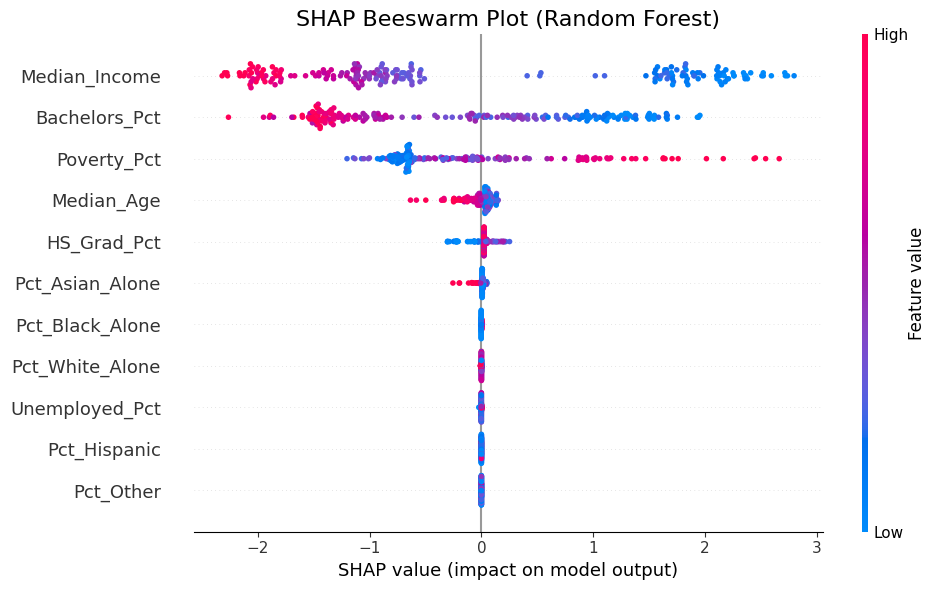

C:\Users\rsaqu\AppData\Local\Temp\ipykernel_16884\3038667432.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


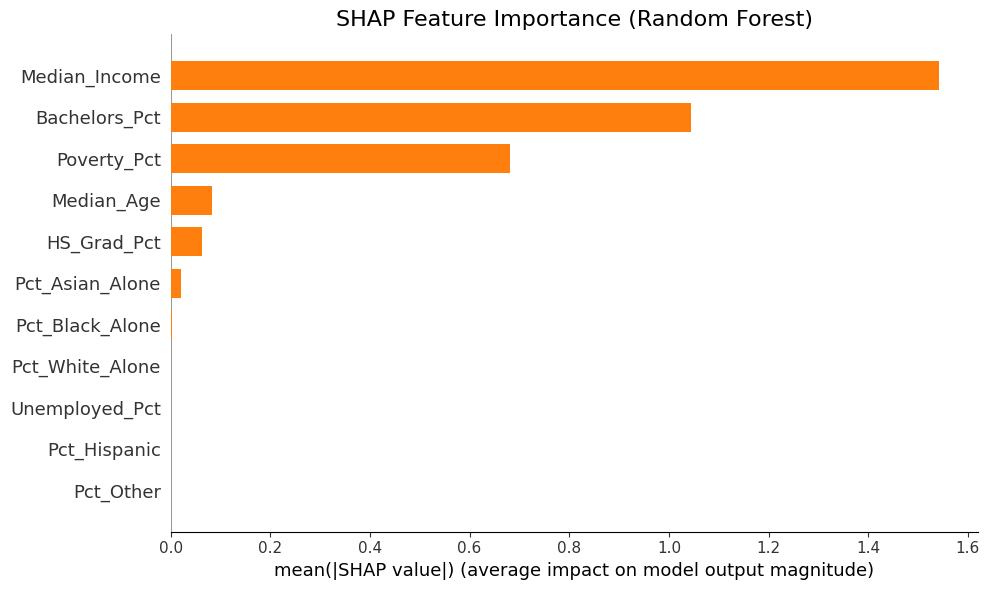

In [25]:
# --------------------------------------------
# SHAP plots (global explanation, prettier but safe)
# --------------------------------------------
import matplotlib.pyplot as plt
import shap

shap.initjs()

# --- 1) Beeswarm plot (SHAP value distribution) ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    rf_shap_values,
    X_test_shap,
    feature_names=X_test_shap.columns,
    show=False,
    plot_size=(10, 6)
)
plt.title("SHAP Beeswarm Plot (Random Forest)", fontsize=16)
plt.tight_layout()
plt.show()

# --- 2) Bar plot (mean |SHAP|) ---
plt.figure(figsize=(10, 6))
shap.summary_plot(
    rf_shap_values,
    X_test_shap,
    feature_names=X_test_shap.columns,
    plot_type="bar",
    show=False,
    plot_size=(10, 6),
    color="tab:orange"
)
plt.title("SHAP Feature Importance (Random Forest)", fontsize=16)
plt.tight_layout()
plt.show()




📊 Interpretation of SHAP Results for the Random Forest Model
1. Which features matter most?

- The SHAP feature importance rankings show that the Random Forest model relies most heavily on socioeconomic indicators to predict county-level mental health outcomes:

- Median Income is the strongest predictor. 
- Higher income strongly reduces predicted poor mental health.

- Bachelors_Pct (share of adults with a bachelor’s degree) is the second-most influential factor.
Higher education levels are associated with better mental health predictions.

- Poverty_Pct is the third most important predictor and tends to increase predicted poor mental health.

- These three variables alone account for the majority of the model’s predictive power, indicating that socioeconomic conditions are far more influential than demographic composition.

2. How do these features influence predictions? (Beeswarm plot)

- The SHAP beeswarm plot helps explain directionality:

- Higher Median Income (red points) is associated with lower SHAP values, meaning income pushes predictions downward (better mental health).

- Higher Poverty_Pct (red) produces positive SHAP values, meaning poverty pushes predictions upward (worse mental health).

- Higher Bachelors_Pct (red) is linked to negative SHAP values, again suggesting protective effects.

- Demographic features such as racial composition (Pct_Hispanic, Pct_Asian_Alone, Pct_Black_Alone) appear farther down the plot and have much smaller SHAP impacts, implying weaker influence on the model’s predictions.

3. Overall interpretation

- In summary, the Random Forest model learns that:

- Economic well-being (income, poverty) and educational attainment are the primary structural drivers of mental health disparities across counties.

- Age contributes moderately, with younger counties showing slightly higher predicted poor mental health.

- Demographic composition by race plays a comparatively minor role in model predictions.

- These findings align with existing public health research: socioeconomic conditions are among the strongest predictors of population-level mental health outcomes.

## PDP Plots 

### PDP for Income & Education

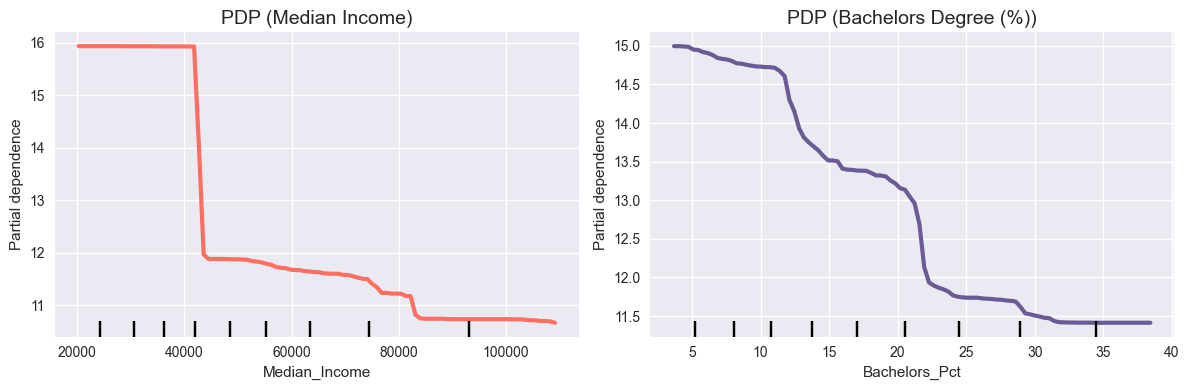

In [26]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

pretty_colors = ["#FF6F61", "#6B5B95"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- Median_Income PDP ---
disp = PartialDependenceDisplay.from_estimator(
    best_rf, X_trval, ["Median_Income"], ax=axes[0]
)
line = disp.lines_[0][0]      # <-- FIXED HERE
line.set_color(pretty_colors[0])
line.set_linewidth(3)

axes[0].set_title("PDP (Median Income)", fontsize=14)
axes[0].set_xlabel("Median Income")
axes[0].set_ylabel("Predicted Mental Health (%)")
axes[0].grid(alpha=0.3)

# --- Bachelors_Pct PDP ---
disp = PartialDependenceDisplay.from_estimator(
    best_rf, X_trval, ["Bachelors_Pct"], ax=axes[1]
)
line = disp.lines_[0][0]      # <-- FIXED HERE
line.set_color(pretty_colors[1])
line.set_linewidth(3)

axes[1].set_title("PDP (Bachelors Degree (%))", fontsize=14)
axes[1].set_xlabel("Bachelors Degree (%)")
axes[1].set_ylabel("Predicted Mental Health (%)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



The PDP for Median Income shows a steep, monotonic decline in predicted poor mental-health days as income rises. Counties below $45k have the highest predicted mental-health burden, but once income passes ~$50k the curve flattens, suggesting diminishing marginal returns to income. The model is essentially saying: most of the economic stress signal lives at the low-income end.

The PDP for Bachelors_Pct shows a similar downward slope—counties with more adults holding bachelor’s degrees have fewer predicted poor mental-health days. The decline is smoother than income, but the pattern is still monotonic, indicating that educational attainment acts as a protective social determinant in this model.

Taken together, these plots show that the Random Forest learned a consistent socioeconomic gradient: higher income and higher educational attainment are strongly associated with better county-level mental-health outcomes, independent of other variables in the model.

### PDP for Race

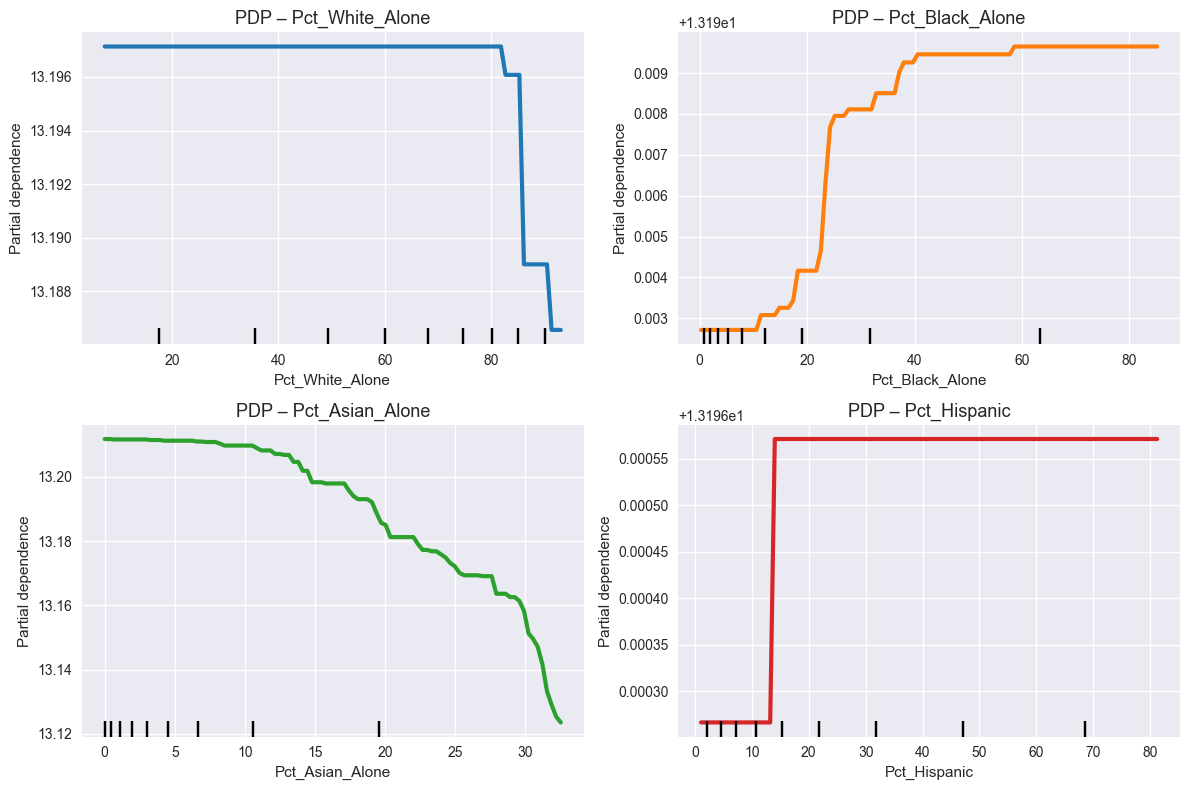

In [28]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")   # same style as before

race_features = [
    "Pct_White_Alone",
    "Pct_Black_Alone",
    "Pct_Asian_Alone",
    "Pct_Hispanic"
]

race_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # blue, orange, green, red

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for feature, color, ax in zip(race_features, race_colors, axes.ravel()):
    disp = PartialDependenceDisplay.from_estimator(
        best_rf,
        X_trval,
        [feature],
        ax=ax
    )
    # Get the PDP line from the display and style it
    line = disp.lines_[0][0]
    line.set_color(color)
    line.set_linewidth(3)

    ax.set_title(f"PDP – {feature}", fontsize=13)
    ax.set_xlabel(feature)
    ax.set_ylabel("Predicted Mental Health (%)")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Pct_White_Alone

- The relationship is nearly flat across most of the distribution, indicating that the Random Forest assigns very little influence to White population share. Only at extremely high values (80–90%) is there a small downward dip, but the effect size is minimal.

### Pct_Black_Alone

- There is a small upward slope as the Black population share increases, but the changes are extremely small (fractions of a percent). This suggests the model does not strongly rely on this feature; the pattern may reflect minor nonlinear structure rather than a substantial effect.

### Pct_Asian_Alone

- A mostly monotonic downward slope: as Asian population share increases, predicted mental-health prevalence decreases. This feature shows a more substantial effect than the Black or Hispanic predictors.

### Pct_Hispanic

- The PDP for Hispanic share is nearly flat, indicating the model is largely insensitive to variation in this feature. There is a small upward bump after ~15%, but the effect size is extremely small, suggesting minimal influence on predictions

Income and education drive the model.
Race variables show small, weak, and nonlinear effects, consistent with the SHAP results that their overall influence is minor compared to socioeconomic factors.

📝 How to interpret these responsibly

- PDPs show associations in the model, not causal effects.

- They help us understand which directions and shapes the Random Forest learned from the data.

- Combined with SHAP, the PDPs confirm that income and education dominate overall influence, while race variables have smaller but still meaningful nonlinear effects.